# Load Data

In [2]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [200]:
#Check if TPU is available
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experiment_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas: ', strategy.num_replicas_in_sync)

Number of replicas:  1


In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
import cv2
import imghdr

In [5]:
print(os.getcwd())
data_dir = 'data'
image_exts = ['jpeg','jpg', 'bmp', 'png']

/Users/hyunjoonrhee/GitHub/chest_xray


### Remove faulty images

In [26]:
for image_class in os.listdir(data_dir): 
    if image_class == '.DS_Store':
        continue
    for chest_condition in os.listdir(os.path.join(data_dir, image_class)):
        if chest_condition == '.DS_Store':
            continue
        for image in os.listdir(os.path.join(data_dir, image_class, chest_condition)):
            if image == '.DS_Store':
                continue
            image_path = os.path.join(data_dir, image_class, chest_condition, image)
            try: 
                img = cv2.imread(image_path)
                tip = imghdr.what(image_path)
                if tip not in image_exts: 
                    print('Image not in ext list {}'.format(image_path))
                    os.remove(image_path)
            except Exception as e: 
                print('Issue with image {}'.format(image_path))
                # os.remove(image_path)

### Load Data

In [27]:
import numpy as np
from matplotlib import pyplot as plt

In [77]:
tf.keras.utils.image_dataset_from_directory??

Signature:
tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs,
)
Source:   
@keras_export(
    "keras.utils.image_dataset_from_directory",
    "keras.preprocessing.image_dataset_from_directory",
    v1=[],
)
def image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs,
):
    """Generates a `tf.data.Dataset` from image files in a directory.

    If your directory structure is:



In [229]:
train_dir = os.path.join(data_dir,'train')
test_dir = os.path.join(data_dir,'test')
val_dir = os.path.join(data_dir,'val')

In [300]:
train_data = tf.keras.utils.image_dataset_from_directory(train_dir)
test_data = tf.keras.utils.image_dataset_from_directory(test_dir)
val_data = tf.keras.utils.image_dataset_from_directory(val_dir)

print('Images are loaded in batches of 32')

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Images are loaded in batches of 32


In [228]:
print('Number of training data: ',len(train_data), '  Number of testing data: ', len(test_data), '  Number of validation data: ', len(val_data))
print('Ratio between training to testing data is', len(train_data)/len(test_data))

Number of training data:  163   Number of testing data:  20   Number of validation data:  1
Ratio between training and testing data is 8.15


In [227]:
print('Number of NORMAL X-ray data: ', len(os.listdir(os.path.join(train_dir,'NORMAL'))))
print('Number of Pneumonia X-ray data: ', len(os.listdir(os.path.join(train_dir,'PNEUMONIA'))))

Number of NORMAL X-ray data:  1342
Number of Pneumonia X-ray data:  3876


Looking at the number of data, there seems to be several issues with how the data are distributed.
1. There are only 16 validation data
- This could be solved by adding more to this from the training folder
2. The number of normal X-ray data is nearly 3 times greater than the number of Pneumonia dataset (Imbalance in our data)

How to solve an imbalance in binary classification data:
1. Oversample or Undersample the data
- Oversampling the smaller data(Normal) by duplicating or creating synthetic samples
    - Data augmentation
    - Variational Autoencoders(VAEs)
    - Generative Adversarial networks(GANs)
- Undersampling the bigger data(Pneumonia) by randomly removing samples
    - Random undersampling, Tomek Links, Edited Nearest Neighbors
2. Class Weighting
- Assign higher weights to the minority class(NORMAL) during model training
3. Ensemble methods
- Train multiple models on different subsets of data and combine their predictions
4. Adjust Decision Threshold
- Adjust the decision threshold of the classifier based on the class imbalance

### Update loaded data based on the issue

In [301]:
validation_split = 0.2
train_data = tf.keras.utils.image_dataset_from_directory(train_dir,
    validation_split = validation_split,
    labels = 'inferred',
    subset = 'training',
    seed = 47
)
test_data = tf.keras.utils.image_dataset_from_directory(test_dir,
    labels = 'inferred',
)
val_data = tf.keras.utils.image_dataset_from_directory(val_dir,
    labels = 'inferred',
)
val_data_from_train = tf.keras.utils.image_dataset_from_directory(train_dir,
    validation_split = validation_split,
    subset = 'validation',
    labels = 'inferred',
    seed = 47
)

#labels sorted according to the alphanumeric order of the image file paths obtained from os.walk(directory)
#Normal = 0, Pneumonia = 1

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.


In [302]:
#Merge validation data
#1. from train_data split  2. from original validation data
val_data = val_data.concatenate(val_data_from_train)
print(len(val_data))

34


In [244]:
normal_img = cv2.imread(os.path.join(train_dir,'NORMAL','IM-0115-0001.jpeg'))
normal_img.shape

(1858, 2090, 3)

In [245]:
bacteria_img = cv2.imread(os.path.join(train_dir,'PNEUMONIA','person1_bacteria_1.jpeg'))
virus_img = cv2.imread(os.path.join(train_dir,'PNEUMONIA','person80_virus_150.jpeg'))
print(bacteria_img.shape,virus_img.shape)


(439, 712, 3) (880, 1248, 3)


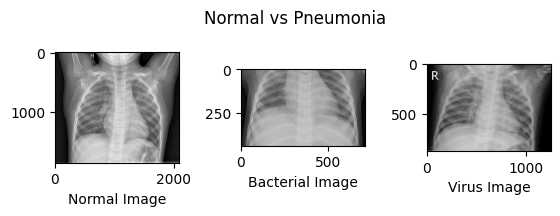

In [253]:
f, ax = plt.subplots(1,3)
ax[0].imshow(normal_img)
ax[1].imshow(bacteria_img)
ax[2].imshow(virus_img)


ax[0].set_xlabel('Normal Image')
ax[1].set_xlabel('Bacterial Image')
ax[2].set_xlabel('Virus Image')

plt.suptitle('Normal vs Pneumonia', y=0.7)
plt.subplots_adjust(wspace=0.5)
plt.show()

In [303]:
train_iterator = train_data.as_numpy_iterator() #makes it possible to go through loops (possible to access the pipeline)
test_iterator = test_data.as_numpy_iterator()
val_iterator = val_data.as_numpy_iterator()

In [304]:
train_batch = train_iterator.next() #get another batch from the iterator
test_batch = test_iterator.next()
val_batch = val_iterator.next()

In [305]:
train_batch[0] #images as numpy arrays
train_batch[1] #1 and 0 are normal and pneumonia each

array([1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0], dtype=int32)

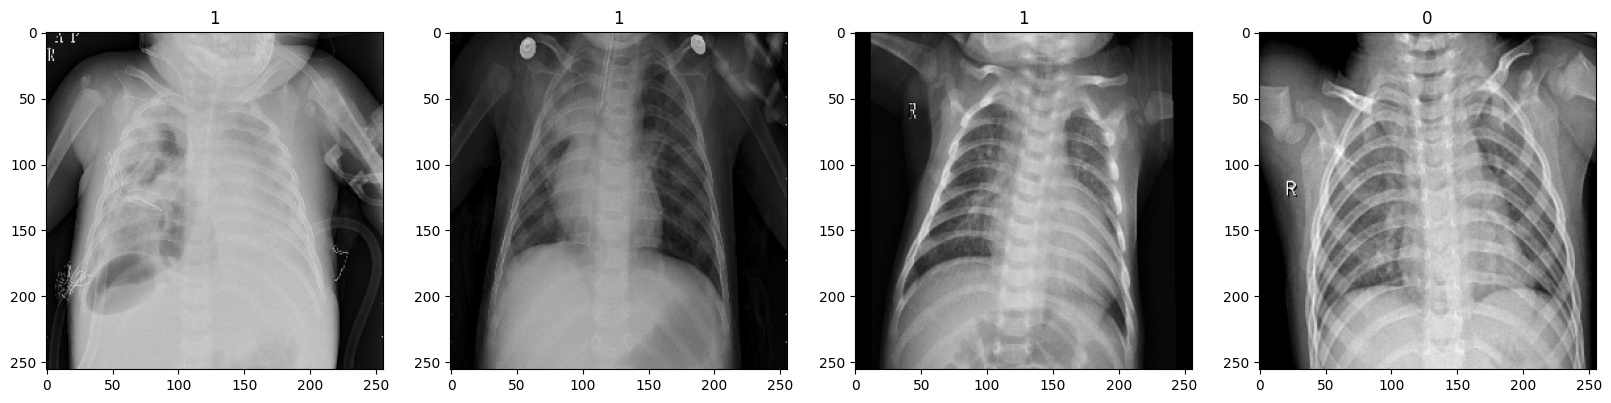

In [306]:
f, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(train_batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    #ax[idx].imshow(img)
    ax[idx].title.set_text(train_batch[1][idx])

### Preprocessing

In [307]:
max_pixel = 255 # ** it's generally better to instantiate constant variables than using hard-coding numbers
train_data = train_data.map(lambda x,y: (x/max_pixel, y)) #x = image, y = labels
test_data = test_data.map(lambda x,y: (x/max_pixel, y))
val_data = val_data.map(lambda x,y: (x/max_pixel, y))

#zip, from generator etc 

In [309]:
train_data.as_numpy_iterator().next()[0].min()

0.0

In [310]:
len(train_data)

131

In [267]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Optimizer

In [345]:
model = Sequential()

In [346]:
#Relu
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))#16 filters, (3,3) kernel, 1 stride
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

#sigmoid, softmax, etc

In [347]:
model.compile('rmsprop', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
#adam optimizer used
#binarycrossentropy because it's classifying between normal and pneumonia

In [348]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 30, 30, 16)       

### Train

In [335]:
#Finetune a model
#learning rate scheduling

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [349]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('pneumoniamodel.h5')
earlystopping = tf.keras.callbacks.EarlyStopping(patience=0,restore_best_weights=True)

In [337]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')

In [350]:
#hist_3 = model.fit(train_data, epochs=3, validation_data=val_data, callbacks=[tensorboard_callback])
hist_10 = model.fit(train_data,
    epochs=20, 
    validation_data=val_data,
    callbacks=[checkpoint,earlystopping,tensorboard_callback])

Epoch 1/20


2023-07-08 01:25:18.102093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 0.7059 - accuracy: 0.8239

2023-07-08 01:25:57.200462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 44s 312ms/step - loss: 0.7059 - accuracy: 0.8239 - val_loss: 0.2437 - val_accuracy: 0.9112
Epoch 2/20


/Users/hyunjoonrhee/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


131/131 [==============================] - 32s 240ms/step - loss: 0.1964 - accuracy: 0.9358 - val_loss: 0.1370 - val_accuracy: 0.9594
Epoch 3/20
131/131 [==============================] - 34s 250ms/step - loss: 0.1518 - accuracy: 0.9516 - val_loss: 0.1120 - val_accuracy: 0.9622
Epoch 4/20
131/131 [==============================] - 34s 256ms/step - loss: 0.1179 - accuracy: 0.9597 - val_loss: 0.1102 - val_accuracy: 0.9679
Epoch 5/20
131/131 [==============================] - 37s 280ms/step - loss: 0.0889 - accuracy: 0.9727 - val_loss: 0.1897 - val_accuracy: 0.9471


In [193]:
hist_3.history

{'loss': [0.541104793548584, 0.1730131059885025, 0.10253874957561493],
 'accuracy': [0.7914111018180847, 0.932323694229126, 0.9626150727272034],
 'val_loss': [0.6276563405990601, 0.17498627305030823, 0.15178734064102173],
 'val_accuracy': [0.5625, 0.875, 0.9375]}

### Plot performance

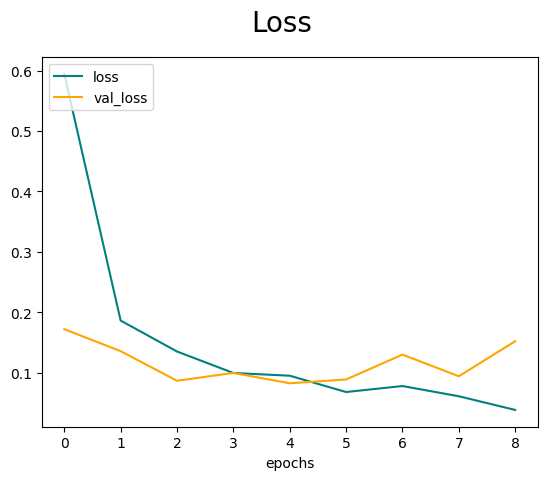

In [339]:
fig = plt.figure()
plt.plot(hist_10.history['loss'], color='teal', label='loss')
plt.plot(hist_10.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.xlabel('epochs')
plt.show()

Looking at the result, the way that the validation loss remains the same could mean that the variance could be the problem.

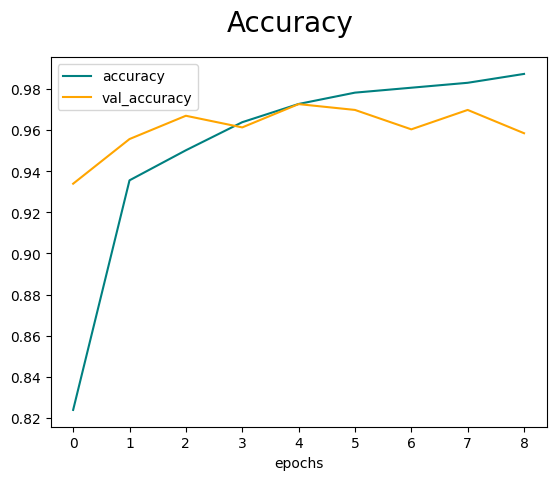

In [340]:
fig = plt.figure()
plt.plot(hist_10.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist_10.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.xlabel('epochs')
plt.show()

### Evaluate

In [284]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [341]:
#3 metrics used for classifications
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [342]:
for batch in test_data.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 212ms/step


2023-07-08 01:17:45.872504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 97ms/step


2023-07-08 01:17:47.766566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [343]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.7166666388511658, Recall: 0.992307722568512, Accuracy: 0.75


### Test

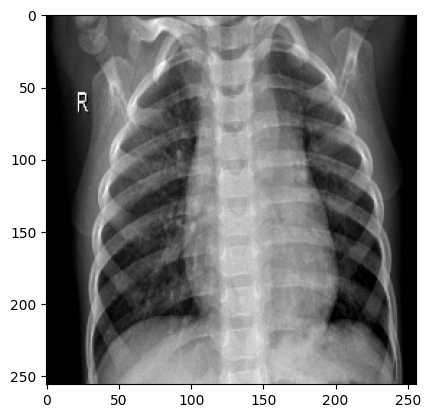

In [326]:
#normal: IM-0001-0001.jpeg
#IM-0003-0001
#IM-0101-0001
#pnemonia: person1_virus_6.jpeg
#person14_virus_44
#person23_virus_56


img = cv2.imread(os.path.join(test_dir,'NORMAL','IM-0101-0001.jpeg'))
img_resize = tf.image.resize(img,(256,256))
plt.imshow(img_resize.numpy().astype(int))


In [ ]:
pred = model.predict(np.expand_dims(img_resize/255,0))

In [328]:
print(pred[0][0])

0.9789808


### Save model

In [196]:
from tensorflow.keras.models import load_model

In [329]:
model.save(os.path.join('models','pneumoniamodel.h5'))

In [199]:
new_model = load_model(os.path.join('models','pneumoniamodel.h5'))